# Identify Fraud from Enron Email

# 背景介绍

安然公司是一家美国能源，商品和服务公司，总部位于德克萨斯州休斯顿。该公司成立于1985年，是休斯顿天然气公司和InterNorth公司合并的结果，这两家公司是美国相对较小的地区性公司。在2001年12月2日破产之前，安然公司雇佣了大约2万名员工，是世界上主要的电力，自然天然气，通信和纸浆和纸制品公司，在2000年宣称收入近1010亿美元。财富连续六年命名安然“美国最具创新力的公司”。

截至2001年年底，据透露，其报告的财务状况是由制度化，有系统和创造性地计划的会计欺诈持续的，这被称为安然事件丑闻。安然已经成为一个着名的例子，故意的企业欺诈和腐败。安然于2001年年底在纽约南区申请破产，并选择Weil，Gotshal＆Manges作为其破产律师。根据法院批准的重组计划，在美国历史上最复杂的破产案之一后，它于2004年11月终止了破产。新董事会将安然公司的名称改为安然信用恢复公司，并强调重组和清算破产前安然公司的某些业务和资产。 2006年9月7日，安然公司将其最后剩余业务Prisma Energy International Inc.出售给Ashmore Energy International Ltd.（现为AEI）。

## 分析结果：

### Overview

数据集中有146个人，其中18个被标识为POI，其余128个是非POI。 

对于数据集中的每个人，我们有19个功能。 一些功能是财务相关的，如一个人的工资。某些功能与该人的电子邮件相关，例如该人已向其发送电子邮件。 

数据集中有许多缺失值，数据集中146个人中有128个没有`restricted_stock_deferred`功能的值，146个人中有129个没有功能`director_fees`的值。

**Missing Values in the Dataset**

这个数据集中的一个明显的异常值被命名为TOTAL，它是所有人的摘要，而不是个人的摘要。

我们可以通过计算数据集中所有其他人的工资总和来验证这一点，结果与TOTAL的工资完全相同。所以我们从数据集中删除TOTAL，否则它将是一个异常值，并影响我们的分类器的性能。 从我们的数据库中删除TOTAL后，我们有145剩人。

### Features

我们在这个项目中创建了两个新`features`。

一个是`to_poi_message_ratio`，记录一个人向POI发送电子邮件的频率。 

另一个称为`from_poi_message_ratio`，记录一个人从POI接收电子邮件的频率。 

在创建这两个特征之后，我们在数据集中具有21个特征。 后来我们进行了特征选择，不幸的是这两个特征都没有在这个过程之后。

### Feature Selection

在这部分，我们使用`cross validation`执行功能选择，并选择储存最佳数量的功能。我们使用来自scikit-learn的`f_classif`函数中SelectKBest方法的评分函数，并获得k = 1,2 ... 21的最佳feature。同时，在每种情况下，构建随机森林分类器以及adaboost分类器，并通过交叉验证测试表现。

你可以查看代码中输出的图形，来查看。

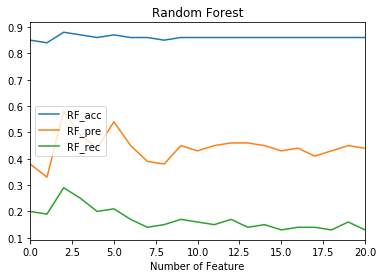

In [30]:
rfdf.plot()
plt.title('Random Forest')
plt.xlabel('Number of Feature')
plt.show()

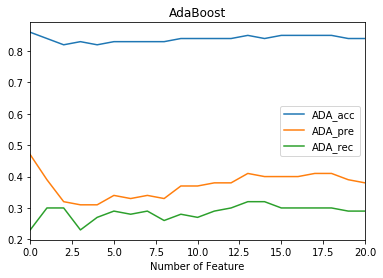

In [31]:
adadf.plot()
plt.title('AdaBoost')
plt.xlabel('Number of Feature')
plt.show()

>在分析过程中有非常详细的图形推导过程，在这里直接引用两图。

由得到的两幅图，我们可以看到两个classifier的精度在使用的不同数量的features大致相同。 随机森林分类器倾向于具有比AdaBoost分类器更好的表现。而无论使用多少特征，两个分类器的召回评分都相对较低。当我们使用`SelectKBest`中最好的3个特征时，对于两个分类器获得最高的回叫分数。

我们所选的三个特征是`bonus，total_stock_value`和`exercised_stock_options`。

我们还从使用这三个特征拟合的随机森林模型中获得了这三个feature的重要性，

重要性分数为0.33,0.36和0.30。 所以有三个剩余的功能具有大致相同的重要性分数。 

使用SelectKBest的这三个特征的特征分数分别是21.06,24.47和25.10。我们没有执行任何特征缩放，因为我们使用的分类器是不需要特征缩放的基于树的classifier。

### 调整模型

在`feature selection`的部分中，我们注意到两个分类器的Recall Score相对较低。在这部分中，我们使用GridSearchCV找到最佳的超参数，以获得随机森林分类器和adaboost分类器的更高的得分。 

这些超参数决定了分类器的复杂性，同时我们希望得到正确的值，以便我们的分类器对未来数据执行得更好。

针对随机森林classifier，我们调整了`max_features，min_sample_splits`以及`n_estimators`的值。 `max_features`和`n_estimators`的值越高，我们的分类器将具有越高的复杂性。 `min_sample_splits`与我们的classifier的复杂性呈负相关。

我们找到的关于Recall Score的最佳值是：

* max_features，2
* min_samples_spli，2
* n_estimators，100

对于adaboost classifier，我们调整`n_estimators`和`learning_rate`的值，并发现它们对于rall score的最佳值分别是：200和0.6。

### Validate and Evaluate

交叉验证是一种统计学上将数据样本切割成较小子集的实用方法,可以先在一个子集上做分析，而其它子集则用来做后续对此分析的确认及验证,来预测模型拟合性能。我们用其来提取关于我们的classifier的性能的信息。我们在特征选择部分以及在算法参数调节部分中使用这种方法。交叉验证的目的是测量算法在样本案例中如何工作。 它比我们简单地用我们手头的样本数据测量算法更可靠。 由于我们的数据集中的观测数量相当小，并且数据集中POI的比例相对较低，因此我们使用`StratifiedShuffleSplit`方法在此项目中进行交叉验证。

给出Precision的定义：

$$Precision=\frac{被正确分类为POI的人数}{被分类为POI的人数}$$

给出Recall的定义：

$$Recall=\frac{被正确分类为POI的人数}{POI的人数}$$

我们可以发现，从调整的随机森林模型中获得了较高的Precision和Recall，因此我们选择它作为最终的classifier。

## Final Remark

最开始，我认为这个项目比较困难，因为任务是预测谁是POI和一些给我们的feature，像个人发送到POI的电子邮件的数量是只有当POI被正确识别的信息。

我们认为使用这些功能就像开挂。但是使用交叉验证选择的最终功能不包含这些类型的功能。因此，我们得到一些信心，分类器应可以在现实生活中发挥良好的作用。

## 学习总结

1. 确定一个问题，并找到可以回答这个问题的数据集。
2. 特征选择，找到机器学习算法适用的特征空间。
3. 应用选择，选择一个合适的算法，注意此算法时候有理想的参数链？
4. 验证，确保结果的可靠性。

## 引导问题分析：

### Dataset/Question：

1. 我的数据量足够满足我的分析吗？
* 我能够定义一个问题吗？
* 有足够的特征来回答这一个问题吗？

>备注： 本文使用Python3.5环境运行，有对原文件进行微小的调整。

## Reviewer's Suggestions

* 这个数据集很不平衡（imbalance）, 也就说明accuracy并不是很好的评估指标，选择precision和recall更好一些。
* 在交叉验证的时候，因为数据的不平衡性，我们会选用Stratified Shuffle Split的方式将数据分为验证集和测试集。
* 数据较小，因此我们可以使用GridSearchCV来进行参数调整，如果较大的数据则会花费较长的时间，可以考虑使用RandomizedSearchCV.

## 分析过程

导入包：

In [1]:
import sys
import pickle
sys.path.append("../tools/")
from tester import dump_classifier_and_data
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.cross_validation import train_test_split, StratifiedShuffleSplit
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import recall_score, accuracy_score, precision_score
from sklearn.preprocessing import MinMaxScaler
from tester import test_classifier
import pandas as pd
import numpy as np
from time import time
from matplotlib import pyplot as plt

from feature_format import featureFormat, targetFeatureSplit

C:\Users\Cheng\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Cheng\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Task 1: Select what features you'll use.

feature_list: 存储特征的名的list

In [2]:
### The first feature must be "poi".
features_list = ['poi','salary' , 'deferral_payments', 'total_payments', 'loan_advances',
                 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 
                 'expenses', 'exercised_stock_options', 'other', 'long_term_incentive', 
                 'restricted_stock', 'director_fees', 'to_messages', 'from_poi_to_this_person', 
                 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi']

In [3]:
print("number of features to start with: ",len(features_list) - 1)

number of features to start with:  19


In [4]:
### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "rb") as data_file:
    data_dict = pickle.load(data_file)

Data Statistics

In [5]:
len(data_dict)

146

共有146条数据

输出数据中的人名：

In [6]:
s = []
for person in data_dict.keys():
    s.append(person)
    if len(s) == 4:
        print('{:<30}{:<30}{:<30}{:<30}'.format(s[0],s[1],s[2],s[3]))
        s = []
print('{:<30}{:<30}'.format(s[0],s[1]))

FALLON JAMES B                DONAHUE JR JEFFREY M          PIRO JIM                      GILLIS JOHN                   
FOWLER PEGGY                  UMANOFF ADAM S                HAYES ROBERT E                OVERDYKE JR JERE C            
MORDAUNT KRISTINA M           DETMERING TIMOTHY J           CHRISTODOULOU DIOMEDES        GIBBS DANA R                  
BUCHANAN HAROLD G             BIBI PHILIPPE A               WASAFF GEORGE                 JACKSON CHARLENE R            
STABLER FRANK                 DODSON KEITH                  THORN TERENCE H               BAZELIDES PHILIP J            
BANNANTINE JAMES M            GAHN ROBERT S                 BERBERIAN DAVID               WODRASKA JOHN                 
LOCKHART EUGENE E             MCCONNELL MICHAEL S           WINOKUR JR. HERBERT S         MEYER JEROME J                
POWERS WILLIAM                CORDES WILLIAM R              MENDELSOHN JOHN               KOENIG MARK E                 
YEAP SOON                     SU

求解`npoi`的数量

In [7]:
npoi=0
for p in data_dict.values():
    if p['poi']:
        npoi+=1

In [8]:
npoi

18

审计，每个特征的缺省值。

In [9]:
NaNInFeatures = [
    0 for i in range(len(features_list))
]

In [10]:
for i, person in enumerate(data_dict.values()):
    for j, feature in enumerate(features_list):
        if person[feature] == 'NaN':
            NaNInFeatures[j] += 1

In [11]:
NaNInFeatures = [
    0 for i in range(len(features_list))
]

for i, person in enumerate(data_dict.values()):
    for j, feature in enumerate(features_list):
        if person[feature] == 'NaN':
            NaNInFeatures[j] += 1

for i, feature in enumerate(features_list):
    print(feature, NaNInFeatures[i])

print("print out some values of the observation 'TOTAL'")
for name, person in data_dict.items():
	if name == 'TOTAL':
		print(person)

salary  = []
for name, person in data_dict.items():
    if float(person['salary']) > 0:
        salary.append(float(person['salary']))
print ("the sum of salary of all other persons is: ",np.sum(salary)/2 )

poi 0
salary 51
deferral_payments 107
total_payments 21
loan_advances 142
bonus 64
restricted_stock_deferred 128
deferred_income 97
total_stock_value 20
expenses 51
exercised_stock_options 44
other 53
long_term_incentive 80
restricted_stock 36
director_fees 129
to_messages 60
from_poi_to_this_person 60
from_messages 60
from_this_person_to_poi 60
shared_receipt_with_poi 60
print out some values of the observation 'TOTAL'
{'email_address': 'NaN', 'restricted_stock': 130322299, 'from_this_person_to_poi': 'NaN', 'loan_advances': 83925000, 'total_stock_value': 434509511, 'from_messages': 'NaN', 'deferred_income': -27992891, 'deferral_payments': 32083396, 'other': 42667589, 'bonus': 97343619, 'restricted_stock_deferred': -7576788, 'long_term_incentive': 48521928, 'total_payments': 309886585, 'salary': 26704229, 'shared_receipt_with_poi': 'NaN', 'from_poi_to_this_person': 'NaN', 'poi': False, 'director_fees': 1398517, 'exercised_stock_options': 311764000, 'to_messages': 'NaN', 'expenses': 523

As the reviewer has suggested,'TRAVEL AGENCY IN THE PARK' and 'LOCKHART EUGENE E' is also outliers

In [12]:
data_dict.pop('TOTAL')
data_dict.pop('THE TRAVEL AGENCY IN THE PARK')
data_dict.pop('LOCKHART EUGENE E')

{'bonus': 'NaN',
 'deferral_payments': 'NaN',
 'deferred_income': 'NaN',
 'director_fees': 'NaN',
 'email_address': 'NaN',
 'exercised_stock_options': 'NaN',
 'expenses': 'NaN',
 'from_messages': 'NaN',
 'from_poi_to_this_person': 'NaN',
 'from_this_person_to_poi': 'NaN',
 'loan_advances': 'NaN',
 'long_term_incentive': 'NaN',
 'other': 'NaN',
 'poi': False,
 'restricted_stock': 'NaN',
 'restricted_stock_deferred': 'NaN',
 'salary': 'NaN',
 'shared_receipt_with_poi': 'NaN',
 'to_messages': 'NaN',
 'total_payments': 'NaN',
 'total_stock_value': 'NaN'}

In [13]:
len(data_dict)

143

创建两个新的feature：
1. to_poi_message_rati
* from_poi_message_ratio

In [14]:
### Store to my_dataset for easy export below.
my_dataset = data_dict

for person in my_dataset.values():
    person['to_poi_message_ratio'] = 0
    person['from_poi_message_ratio'] = 0
    if float(person['from_messages']) > 0:
        person['to_poi_message_ratio'] = float(person['from_this_person_to_poi'])/float(person['from_messages'])
    if float(person['to_messages']) > 0:
        person['from_poi_message_ratio'] = float(person['from_poi_to_this_person'])/float(person['to_messages'])
    
features_list.extend(['to_poi_message_ratio', 'from_poi_message_ratio'])

### Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

In [15]:
data

array([[  0.00000000e+00,   2.01955000e+05,   2.86971700e+06, ...,
          1.40700000e+03,   2.96127563e-02,   1.61957271e-02],
       [  0.00000000e+00,   0.00000000e+00,   1.78980000e+05, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   4.77000000e+02,   0.00000000e+00, ...,
          4.65000000e+02,   0.00000000e+00,   6.89045936e-02],
       ..., 
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  1.00000000e+00,   1.58403000e+05,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00]])

尝试使用`stratifieldshufflesplit`来查找要使用的功能的最佳子集

Stratified ShuffleSplit cross-validator

Stratified ShuffleSplit cross-validator是StratifiedKFold和ShuffleSplit的合并，它返回分层随机折叠。由于目标分类的分布中表现出很大的不平衡，因此我们采用Stratified ShuffleSplit以确保每个training中的相对类频率大致保持不变。

In [16]:
scv = StratifiedShuffleSplit(labels, 1000, random_state = 42)

开始选择特征：

In [17]:
RF_acc = []
RF_precision = []
RF_recall = []
ADA_acc = []
ADA_precision = []
ADA_recall = []

cvClassifier作用：使用交叉验证来训练和评估分类器.

In [18]:
def cvClassifier(clf, features, labels, cv):
### function to help train and evaluate classifiers using crossvalidation
    true_negatives = 0
    false_negatives = 0
    true_positives = 0
    false_positives = 0
    for train_idx, test_idx in cv: 
        features_train = []
        features_test  = []
        labels_train   = []
        labels_test    = []
        for ii in train_idx:
            features_train.append( features[ii] )
            labels_train.append( labels[ii] )
        for jj in test_idx:
            features_test.append( features[jj] )
            labels_test.append( labels[jj] )
        clf.fit(features_train, labels_train)
        predictions = clf.predict(features_test)
        for prediction, truth in zip(predictions, labels_test):
            if prediction == 0 and truth == 0:
                true_negatives += 1
            elif prediction == 0 and truth == 1:
                false_negatives += 1
            elif prediction == 1 and truth == 0:
                false_positives += 1
            elif prediction == 1 and truth == 1:
                true_positives += 1
    total_predictions = true_negatives + false_negatives + false_positives + true_positives
    accuracy = round(1.0*(true_positives + true_negatives)/total_predictions,2)
    precision = round(1.0*true_positives/(true_positives+false_positives),2)
    recall = round(1.0*true_positives/(true_positives+false_negatives),2)
    return accuracy, precision, recall

查看features的数量

In [ ]:
len(features[0])

在selector的阶段进行21次迭代

In [ ]:
for i in range(len(features[0])):
    t0 = time()
    selector = SelectKBest(f_classif, k = i+1)
    selector.fit(features, labels)
    reduced_features = selector.fit_transform(features, labels)
    cutoff = np.sort(selector.scores_)[::-1][i]
    selected_features_list = [f for j, f in enumerate(features_list[1:]) if selector.scores_[j] >= cutoff]
    selected_features_list = ['poi'] + selected_features_list
    RF = RandomForestClassifier(random_state=1126)
    adaBoost = AdaBoostClassifier(random_state=1126)
    acc, precision, recall = cvClassifier(RF, reduced_features, labels, scv)
    RF_acc.append(acc)
    RF_precision.append(precision)
    RF_recall.append(recall)
    acc, precision, recall = cvClassifier(adaBoost, reduced_features, labels, scv)
    ADA_acc.append(acc)
    ADA_precision.append(precision)
    ADA_recall.append(recall)
    print ("fitting time for k = {0}: {1}".format(i+1, round(time()-t0, 3)))
    print ("RF accuracy: {0}  precision: {1}  recall: {2}".format(RF_acc[-1], RF_precision[-1], RF_recall[-1]))
    print ("ADA accuracy: {0}  precision: {1}  recall: {2}".format(ADA_acc[-1], ADA_precision[-1], ADA_recall[-1]))

将使用不同的最佳k特征的每个分类器的分数用图像表示出来：

In [ ]:
rfdf = pd.DataFrame({'RF_acc': RF_acc, 'RF_pre': RF_precision, 'RF_rec': RF_recall})
adadf = pd.DataFrame({'ADA_acc': ADA_acc, 'ADA_pre': ADA_precision, 'ADA_rec': ADA_recall})                   
rfdf.plot()
plt.show()
adadf.plot()
plt.show()

我们可以在图中看到，使用随机森林模型往往具有更高的精度和更低的召回率。对于adaboost模型，它倾向于具有较高的Recall Score，但精度较低。

In [ ]:
selector = SelectKBest(f_classif, k = ADA_recall.index(max(ADA_recall))+1)
selector.fit(features, labels)
cutoff = np.sort(selector.scores_)[::-1][ADA_recall.index(max(ADA_recall))+1]
selected_features_list = [f for i, f in enumerate(features_list[1:]) if selector.scores_[i] > cutoff]
selected_features_list = ['poi'] + selected_features_list
selected_features = selector.fit_transform(features, labels)

In [ ]:
print("number of features selected: ", len(selected_features_list)-1)

In [ ]:
print("and they are: ")
for f in selected_features_list[1:]:
    print(f)

In [ ]:
RF = RandomForestClassifier(random_state=1126)
RF.fit(selected_features, labels)

这些所选特征的特征重要性是：

In [ ]:
print(RF.feature_importances_)

从SelectKBest中选择的这些特征的特征分数是：

In [ ]:
for f in selected_features_list[1:]:
    print(f, "score is: ", selector.scores_[features_list[1:].index(f)])

Task 5: 调整您的分类器以实现比.3精度更高，并使用我们的test来测试Recall Score。

Check the tester.py script in the final project folder for details on the evaluation method, especially the test_classifier function. Because of the small size of the dataset, the script uses stratified shuffle split cross validation. [For more info](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html)

调整随机森林算法：

In [ ]:
t0 = time()
tuning_parameters = {'n_estimators': [20,50,100], 'min_samples_split': [1,2,4], 'max_features': [1,2,3]}

调整Hyperparameter以进行调用：

In [ ]:
RF = GridSearchCV(RandomForestClassifier(), tuning_parameters, cv=scv, scoring = 'recall')
RF.fit(selected_features, labels)

最佳参数：

In [ ]:
print(RF.best_params_)
print ("调整时长: {0}".format(round(time()-t0, 3)))

In [ ]:
Clf = RF.best_estimator_
print( "measurements for tuned random forest classifier: ")
test_classifier(Clf, my_dataset, selected_features_list, folds = 1000)

调整Adaboost算法：

In [ ]:
t0 = time()
tuned_parameters = {'n_estimators': [50,100,200], 'learning_rate': [0.4,0.6,1]}
print("# Tuning hyper-parameters for recall")
Adaboost = GridSearchCV(AdaBoostClassifier(), tuned_parameters, cv=scv, scoring = 'recall')
Adaboost.fit(selected_features, labels)

最佳参数：

In [ ]:
print(Adaboost.best_params_)
print("调整时长: {0}".format(round(time()-t0, 3)))

In [ ]:
Clf = Adaboost.best_estimator_
print("measurements for tuned adaboost classifier: ")
test_classifier(Clf, my_dataset, selected_features_list, folds = 1000)

Task 4: 尝试各种分类器

请在下面命名您的分类器clf以便于导出。请注意，如果您想要进行PCA或其他多阶段操作，您需要使用pipeline。 For [more info:](http://scikit-learn.org/stable/modules/pipeline.html)

In [ ]:
# Provided to give you a starting point. Try a variety of classifiers.
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()

# Example starting point. Try investigating other evaluation techniques!
from sklearn.cross_validation import train_test_split
features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42)

收尾工作：转储分类器，数据集和features_list，以便任何人都可以检查您的结果。 您不需要更改以下任何内容，但请确保您提交的poi_id.py版本可以独立运行，并生成必要的.pkl文件以验证结果。

In [ ]:
dump_classifier_and_data(clf, my_dataset, features_list)

# Reference

1. [安然公司-维基百科](https://en.wikipedia.org/wiki/Enron)
* [CMU - 安然邮件数据](https://www.cs.cmu.edu/~./enron/)
* [sklearn.feature_selection.SelectKBest](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html)
* [sklearn.grid_search.GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.GridSearchCV.html)
* [sklearn.cross_validation.StratifiedShuffleSplit](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html#sklearn.cross_validation.StratifiedShuffleSplit)
* [Pipeline](http://scikit-learn.org/stable/modules/pipeline.html)
* [Sklearn Examples](http://scikit-learn.org/stable/auto_examples/index.html)
* [Sklearn Ensemble](http://scikit-learn.org/stable/modules/ensemble.html)
* [Preprocessing](http://scikit-learn.org/stable/modules/preprocessing.html)
* [SelectKBest](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html)
* [Pipeline](http://scikit-learn.org/stable/modules/pipeline.html)
* [Dnron_dataset,Darial Alekseeva GitHub](https://github.com/DariaAlekseeva/Enron_Dataset/blob/master/poi_id.py)
* [评分标准](https://review.udacity.com/#!/projects/3174288624/rubric)